In [1]:
import torch
from torch_geometric.data import Data
import networkx as nx

In [2]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='./graph/Cora', name='Cora')
len(dataset)

Processing...
Done!


1

In [3]:
dataset[0].num_nodes, dataset[0].num_edges


(2708, 10556)

In [4]:
data = dataset[0]
data.train_mask.sum().item(), data.val_mask.sum().item(), data.test_mask.sum().item()


(140, 500, 1000)

In [5]:
data.train_mask.shape, data.val_mask.shape, data.test_mask.shape


(torch.Size([2708]), torch.Size([2708]), torch.Size([2708]))

In [6]:
len(data.y.numpy())
set(data.y.numpy())


{0, 1, 2, 3, 4, 5, 6}

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [8]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [16]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [17]:
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9478
Epoch: 002, Loss: 1.8630
Epoch: 003, Loss: 1.7674
Epoch: 004, Loss: 1.6375
Epoch: 005, Loss: 1.5014
Epoch: 006, Loss: 1.3617
Epoch: 007, Loss: 1.2219
Epoch: 008, Loss: 1.1053
Epoch: 009, Loss: 0.9791
Epoch: 010, Loss: 0.9055
Epoch: 011, Loss: 0.7790
Epoch: 012, Loss: 0.6825
Epoch: 013, Loss: 0.6477
Epoch: 014, Loss: 0.5056
Epoch: 015, Loss: 0.4942
Epoch: 016, Loss: 0.4423
Epoch: 017, Loss: 0.4125
Epoch: 018, Loss: 0.3253
Epoch: 019, Loss: 0.3138
Epoch: 020, Loss: 0.2924
Epoch: 021, Loss: 0.2273
Epoch: 022, Loss: 0.2071
Epoch: 023, Loss: 0.2390
Epoch: 024, Loss: 0.2235
Epoch: 025, Loss: 0.1705
Epoch: 026, Loss: 0.1581
Epoch: 027, Loss: 0.1319
Epoch: 028, Loss: 0.1634
Epoch: 029, Loss: 0.1254
Epoch: 030, Loss: 0.1347
Epoch: 031, Loss: 0.0841
Epoch: 032, Loss: 0.1047
Epoch: 033, Loss: 0.0831
Epoch: 034, Loss: 0.0948
Epoch: 035, Loss: 0.0841
Epoch: 036, Loss: 0.0812
Epoch: 037, Loss: 0.0905
Epoch: 038, Loss: 0.0915
Epoch: 039, Loss: 0.0625
Epoch: 040, Loss: 0.0807


In [18]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8090


In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(data.y[data.test_mask].cpu().numpy(), 
                 pred[data.test_mask].cpu().numpy())

array([[ 93,   4,   3,   8,   6,   7,   9],
       [  3,  81,   3,   3,   0,   0,   1],
       [  3,   4, 132,   4,   0,   1,   0],
       [ 18,   9,  10, 239,  32,   7,   4],
       [  9,   1,   2,   6, 126,   4,   1],
       [  6,   3,   4,   0,   0,  81,   9],
       [  4,   0,   0,   1,   0,   2,  57]], dtype=int64)

C:\Users\ian\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\ian\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


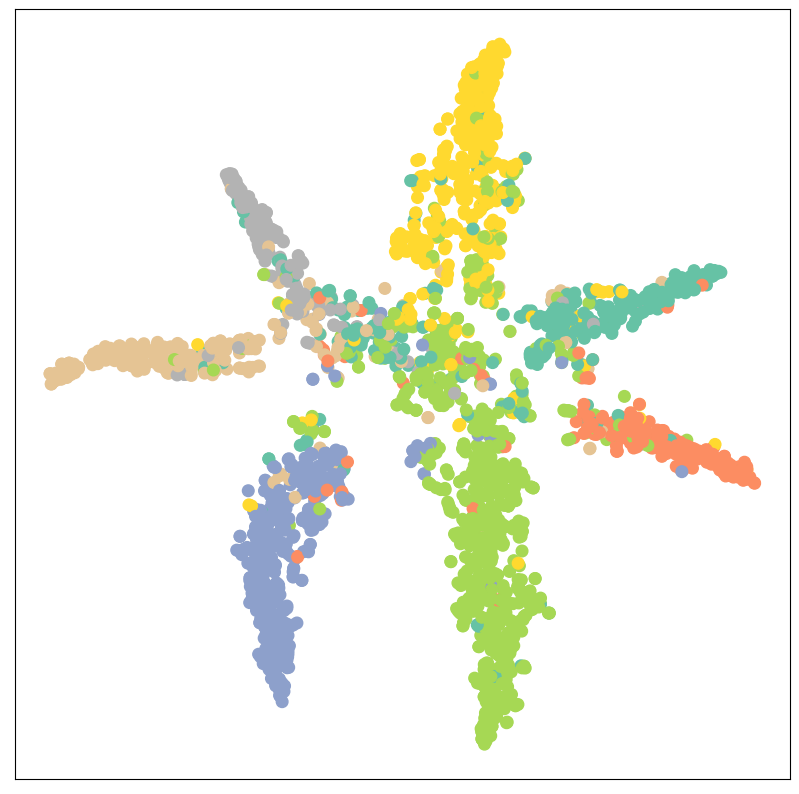

In [20]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

model.eval()
out = model(data)
visualize(out.cpu(), color=data.cpu().y)